In [1]:
import helper
import pandas as pd
#from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

# Introduction

Stock price prediction is one of the most rewarding problems in modern finance, where the accurate forecasting of future stock prices can yield significant profit and reduce the risks. LSTM (Long Short-Term Memory) is a recurrent Neural Network (RNN) applicable to a broad range of problems aiming to analyze or classify sequential data. Therefore, many people have used LSTM to predict the future stock price based on the historical data sequences with great success.

On the other hand, recent studies have shown that the LSTM's efficiency and trainability can be improved by replacing some of the layers in the LSTM with variational quantum layers, thus making it a quantum-classical hybrid model of LSTM which we will call QLSTM for Quantum LSTM. In the study done by Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang, they show that QLSTM offers better trainability compared to its classical counterpart as it proved to learn significantly more information after the first training epoch than its classical counterpart, learnt the local features better, all while having a comparable number of parameters. Inspired by these recent results, we proceed to test this variational quantum-classical hybrid neural network technique on stock price predictions. 

In the following notebook, we show a proof of concept that QLSTM can be used to great effect for stock price prediction, offering comparable and arguably better results than its classical counterpart. To do so, we implement both LSTM and QLSTM to predict the stock prices of the company Merck & Co. Inc (MRK) with the same number of features, of which we chose based on earlier studies done with stock price predictions.

This submission was motivated by a combination of a few separate studies:

Stock price prediction use BERT and GAN: https://arxiv.org/pdf/2107.09055.pdf, Priyank Sonkiya, Vikas Bajpai, Anukriti Bansal <br>
Quantum Long Short-Term Memory: https://arxiv.org/pdf/2009.01783.pdf, Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang <br>

With code and ideas reused and repurposed from the following sources:

Example of a QLSTM: https://github.com/rdisipio/qlstm, Riccardo Di Sipio <br>
How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent <br>
Using GANs to predict stock price movement: https://towardsdatascience.com/aifortrading-2edd6fac689d, Boris Banushev<br>

## Brief Outline

To demonstrate the use of QLSTM for stock prediction, we use the stock prices of the company Merck & Co. Inc (MRK). The notebook will proceed in the following manner:

1. Brief description of Data
2. Using Classical LSTM to perform stock price prediction
3. Defining QLSTM and using it to perform stock price prediction
4. Comparison between LSTM and QLSTM

Note that for the LSTM, we would be using PyTorch; while for the QLSTM we would be using PyTorch and Pennylane. 

# Data

Data Description: We have collected the historical data of the MRK stock prices, of which we focus on the closing price. Our goal is then to forecast the closing stock prices of MRK using LSTM (or QLSTM). 

To achieve this goal, we have collected the following necessary data and information. This includes the following:

- Technical indicators
- Trend approximations (Fourier Transforms)
- ARIMA 
- Correlated assets
- Sentimental analysis

While interesting and important in its own right, we have decided not to go into detail for the data collection in this notebook. For more information, please go take a look at the Data Collection notebook also in this Github. 

In this section, our goal is to process the data necessary for the LSTM and QLSTM.

First, we read in the data, dropping the index and the date.

In [2]:
df = pd.read_csv('dataset_MRK_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,...,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450,31.440840
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,...,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840,31.183207
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,...,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207,31.364504
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,...,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504,30.839695
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,...,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695,30.944656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,1.705192,78.113220,71.292452,...,38.856968,148.141144,82.393753,12302.190430,9682.910156,57.910147,55.622779,55.790021,76.887436,77.814888
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,...,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500,78.492363
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,...,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240,79.103050
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,...,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688,78.492363


We identify the dependent and independent variables:

In [3]:
target = "Close_lead1"

In [4]:
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

In [5]:
len(features)

32

## Data Processing

To process the data, we first split it into training and test data, where two-thirds of the data is used for training, and the last third is used for testing.

In [6]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [7]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [8]:
from Factory import SequenceDataset

Finally, the last step in the data processing to prepare for LSTM is to prepare the data in a sequence of past observations. Preparation of the LSTM on time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance. If the sequence length is $n$, then the LSTM considers the last $n$ observations to predict the $n+1$ th day.

We decided the sequence length as 3 for purposes of this notebook.

In [9]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 32])
Target shape: torch.Size([1])


In [10]:
print(len(train_loader))

1821


Inicialmente se puede observar que el tamaña del batch es 1 con una secuencia de 3. Shuffle =  True es que se mezcla, casi al azar.

In [11]:
df_train

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,-1.367412,0.009724,-1.467094,-1.548950,-1.517050,-1.485346,0.483927,0.004259,-1.502313,-1.585985,...,-1.542295,-1.223130,-1.526392,-1.633607,-1.505769,1.116638,0.661488,0.417660,-1.367501,-1.323510
1,-1.322237,0.802780,-1.438767,-1.538476,-1.498487,-1.459093,0.631273,0.298574,-1.465953,-1.602907,...,-1.573396,-1.217681,-1.504030,-1.615623,-1.499763,1.106391,0.640008,0.386462,-1.322322,-1.350606
2,-1.349342,-0.503571,-1.412885,-1.525696,-1.484328,-1.441353,0.700299,0.443539,-1.440650,-1.603441,...,-1.575542,-1.226244,-1.498744,-1.622022,-1.499571,1.096136,0.618591,0.355414,-1.349429,-1.331539
3,-1.330268,-0.521984,-1.381826,-1.511282,-1.469934,-1.423450,0.767988,0.581768,-1.414362,-1.601669,...,-1.527280,-1.208338,-1.472316,-1.598321,-1.496400,1.085874,0.597239,0.324520,-1.330354,-1.386733
4,-1.385481,-0.205228,-1.369748,-1.499847,-1.461816,-1.417062,0.735804,0.600543,-1.401597,-1.591727,...,-1.574469,-1.228190,-1.481261,-1.607472,-1.495401,1.075603,0.575953,0.293785,-1.385573,-1.375694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,1.444453,-0.790046,1.325599,1.490326,1.499290,1.406282,-1.648395,1.098484,1.543603,1.422397,...,0.460208,1.292560,0.385506,1.027732,1.545663,0.918170,1.607433,1.609781,1.392039,1.810552
1817,1.812877,2.036372,1.404108,1.501137,1.525281,1.471589,-0.900462,1.532956,1.592766,1.392654,...,0.660840,1.518595,0.544018,1.105551,1.600993,0.918721,1.612203,1.615176,1.438596,1.888829
1818,1.891180,0.618294,1.485493,1.516992,1.555199,1.538952,-0.187707,2.019262,1.651437,1.363207,...,0.581227,1.542545,0.532433,1.133133,1.560375,0.919288,1.616942,1.620559,1.794709,1.787471
1819,1.789788,0.078450,1.558970,1.523911,1.575324,1.580280,0.216125,2.256141,1.679235,1.348040,...,0.468170,1.507662,0.501889,1.111639,1.587579,0.919870,1.621649,1.625928,1.875531,1.745322


In [12]:
X[0]

tensor([[ 1.0389, -0.7141,  1.0035,  0.5315,  0.9909,  0.6613,  0.7248,  0.7663,
          0.8726,  1.6448,  0.4965,  0.3123,  0.7496,  0.6944,  0.6348,  0.9098,
          0.7669,  0.6731,  0.8768,  1.2223,  0.4158, -0.4910,  1.0021,  0.9923,
          1.1485,  1.0564,  1.0226,  0.9907, -0.4165,  0.7084, -0.5927,  0.9613],
        [ 1.0275, -0.6781,  1.0018,  0.5418,  0.9507,  0.6084,  0.7269,  0.7726,
          0.8778,  1.5512,  0.5182,  0.2891,  0.5647,  0.7056,  0.6397,  0.9382,
          0.7917,  0.7029,  0.8560,  1.1769,  0.4912, -0.7164,  0.9688,  0.9597,
          1.1478,  1.0591,  1.0068,  0.9505, -0.4165,  0.7084, -0.5927,  0.9671],
        [ 1.0033, -0.4000,  0.9932,  0.4514,  0.8573,  0.5136,  0.7290,  0.7788,
          0.8830,  1.4224,  0.5924,  0.2510,  0.2688,  0.6648,  0.6604,  0.9323,
          0.8253,  0.6883,  0.9059,  1.1461,  0.4646,  1.4080,  0.8954,  0.8832,
          1.1160,  1.0535,  0.9759,  0.8572,  1.0715, -1.6059,  1.2589,  0.9865]])

In [13]:
train_dataset.__len__()

1821

In [12]:
train_dataset[1]

(tensor([[-1.4853,  0.0043, -1.5170, -0.9896, -1.3675, -1.3260,  1.1166,  0.6615,
           0.4177, -1.5423, -1.1818, -1.2231,  0.4839, -1.5058, -1.5264, -1.6336,
          -1.4209, -1.5414, -1.4273, -1.3173, -1.6262,  0.0097, -1.3796, -1.4906,
          -1.5860, -1.5490, -1.4671, -1.3674, -0.4165,  0.7084, -0.5927, -1.5023],
         [-1.4853,  0.0043, -1.5170, -0.9896, -1.3675, -1.3260,  1.1166,  0.6615,
           0.4177, -1.5423, -1.1818, -1.2231,  0.4839, -1.5058, -1.5264, -1.6336,
          -1.4209, -1.5414, -1.4273, -1.3173, -1.6262,  0.0097, -1.3796, -1.4906,
          -1.5860, -1.5490, -1.4671, -1.3674, -0.4165,  0.7084, -0.5927, -1.5023],
         [-1.4591,  0.2986, -1.4985, -0.9900, -1.3223, -1.3091,  1.1064,  0.6400,
           0.3865, -1.5734, -1.1867, -1.2177,  0.6313, -1.4998, -1.5040, -1.6156,
          -1.4135, -1.5349, -1.4256, -1.3147, -1.6328,  0.8028, -1.3415, -1.4273,
          -1.6029, -1.5385, -1.4388, -1.3222, -0.4165,  0.7084, -0.5927, -1.4660]]),
 tensor(-1.

In [14]:
train_dataset[2]

(tensor([[-1.4853,  0.0043, -1.5170, -0.9896, -1.3675, -1.3260,  1.1166,  0.6615,
           0.4177, -1.5423, -1.1818, -1.2231,  0.4839, -1.5058, -1.5264, -1.6336,
          -1.4209, -1.5414, -1.4273, -1.3173, -1.6262,  0.0097, -1.3796, -1.4906,
          -1.5860, -1.5490, -1.4671, -1.3674, -0.4165,  0.7084, -0.5927, -1.5023],
         [-1.4591,  0.2986, -1.4985, -0.9900, -1.3223, -1.3091,  1.1064,  0.6400,
           0.3865, -1.5734, -1.1867, -1.2177,  0.6313, -1.4998, -1.5040, -1.6156,
          -1.4135, -1.5349, -1.4256, -1.3147, -1.6328,  0.8028, -1.3415, -1.4273,
          -1.6029, -1.5385, -1.4388, -1.3222, -0.4165,  0.7084, -0.5927, -1.4660],
         [-1.4414,  0.4435, -1.4843, -0.9717, -1.3494, -1.3110,  1.0961,  0.6186,
           0.3554, -1.5755, -1.2047, -1.2262,  0.7003, -1.4996, -1.4987, -1.6220,
          -1.4167, -1.5346, -1.4239, -1.3232, -1.6216, -0.5036, -1.3469, -1.4652,
          -1.6034, -1.5257, -1.4129, -1.3493, -0.4165,  0.7084, -0.5927, -1.4407]]),
 tensor(-1.

In [14]:
train_dataset[3]

(tensor([[-1.4591,  0.2986, -1.4985, -0.9900, -1.3223, -1.3091,  1.1064,  0.6400,
           0.3865, -1.5734, -1.1867, -1.2177,  0.6313, -1.4998, -1.5040, -1.6156,
          -1.4135, -1.5349, -1.4256, -1.3147, -1.6328,  0.8028, -1.3415, -1.4273,
          -1.6029, -1.5385, -1.4388, -1.3222, -0.4165,  0.7084, -0.5927, -1.4660],
         [-1.4414,  0.4435, -1.4843, -0.9717, -1.3494, -1.3110,  1.0961,  0.6186,
           0.3554, -1.5755, -1.2047, -1.2262,  0.7003, -1.4996, -1.4987, -1.6220,
          -1.4167, -1.5346, -1.4239, -1.3232, -1.6216, -0.5036, -1.3469, -1.4652,
          -1.6034, -1.5257, -1.4129, -1.3493, -0.4165,  0.7084, -0.5927, -1.4407],
         [-1.4234,  0.5818, -1.4699, -0.9923, -1.3304, -1.3169,  1.0859,  0.5972,
           0.3245, -1.5273, -1.2096, -1.2083,  0.7680, -1.4964, -1.4723, -1.5983,
          -1.4073, -1.5270, -1.4031, -1.3009, -1.6500, -0.5220, -1.3359, -1.4385,
          -1.6017, -1.5113, -1.3818, -1.3303, -0.4165,  0.7084, -0.5927, -1.4144]]),
 tensor(-1.

In [15]:
train_dataset[4]

(tensor([[-1.4414,  0.4435, -1.4843, -0.9717, -1.3494, -1.3110,  1.0961,  0.6186,
           0.3554, -1.5755, -1.2047, -1.2262,  0.7003, -1.4996, -1.4987, -1.6220,
          -1.4167, -1.5346, -1.4239, -1.3232, -1.6216, -0.5036, -1.3469, -1.4652,
          -1.6034, -1.5257, -1.4129, -1.3493, -0.4165,  0.7084, -0.5927, -1.4407],
         [-1.4234,  0.5818, -1.4699, -0.9923, -1.3304, -1.3169,  1.0859,  0.5972,
           0.3245, -1.5273, -1.2096, -1.2083,  0.7680, -1.4964, -1.4723, -1.5983,
          -1.4073, -1.5270, -1.4031, -1.3009, -1.6500, -0.5220, -1.3359, -1.4385,
          -1.6017, -1.5113, -1.3818, -1.3303, -0.4165,  0.7084, -0.5927, -1.4144],
         [-1.4171,  0.6005, -1.4618, -1.0056, -1.3856, -1.3470,  1.0756,  0.5760,
           0.2938, -1.5745, -1.2166, -1.2282,  0.7358, -1.4954, -1.4813, -1.6075,
          -1.4125, -1.5324, -1.3762, -1.3061, -1.6519, -0.2052, -1.3691, -1.5161,
          -1.5917, -1.4998, -1.3697, -1.3855, -0.4165,  0.7084, -0.5927, -1.4016]]),
 tensor(-1.

In [15]:
train_dataset[1820]

(tensor([[ 1.5390,  2.0193,  1.5552,  1.2620,  1.7947,  0.9898,  0.9193,  1.6169,
           1.6206,  0.5812,  1.9176,  1.5425, -0.1877,  1.5604,  0.5324,  1.1331,
           1.4082,  1.4863,  0.4842,  0.2359,  0.9946,  0.6183,  1.8231,  1.6654,
           1.3632,  1.5170,  1.4855,  1.8912, -0.1857, -2.1643,  2.7810,  1.6514],
         [ 1.5803,  2.2561,  1.5753,  1.2034,  1.8755,  0.9727,  0.9199,  1.6216,
           1.6259,  0.4682,  1.8705,  1.5077,  0.2161,  1.5876,  0.5019,  1.1116,
           1.2851,  1.4782,  0.3925,  0.2129,  0.9946,  0.0785,  1.8024,  1.5945,
           1.3480,  1.5239,  1.5590,  1.7898,  0.2628,  0.1050, -0.3037,  1.6792],
         [ 1.6087,  2.4326,  1.5908,  1.1657,  1.7777,  0.9839,  0.9205,  1.6263,
           1.6313,  0.4347,  1.7883,  1.4738,  0.4634,  1.5696,  0.4255,  1.1306,
           1.2564,  1.4776,  0.4389,  0.2464,  0.9434, -0.4802,  1.7674,  1.5647,
           1.3383,  1.5306,  1.6323,  1.7476,  4.1892, -1.9634, -0.3766,  1.7014]]),
 tensor(1.7

In [16]:
print(len(test_loader))

897


In [17]:
test_dataset[896]

(tensor([[ 3.4356,  2.3599,  3.3862,  3.5676,  3.5736,  1.6562,  1.3596,  1.1926,
           1.1997,  2.1883,  3.8226,  5.9029,  1.1987,  5.9857,  2.4335,  2.4833,
           2.4345,  4.2078,  2.4449, -1.1177,  3.0858, -0.5069,  3.6076,  2.7316,
           3.1607,  3.3042,  3.5020,  3.6279, -0.3332, -2.0024,  2.6803,  3.4156],
         [ 3.4792,  2.5970,  3.4129,  3.5697,  3.6091,  1.6627,  1.3496,  1.1700,
           1.1663,  2.3162,  3.7969,  5.9029,  1.5220,  6.0921,  2.4187,  2.6179,
           2.5279,  4.3097,  2.5414, -1.0448,  3.1269, -0.5688,  3.6665,  2.7666,
           3.1743,  3.3393,  3.5575,  3.6921, -0.4165,  0.7084, -0.5927,  3.4708],
         [ 3.5061,  2.7876,  3.4328,  3.5478,  3.6859,  1.6300,  1.3396,  1.1474,
           1.1329,  2.2226,  3.7575,  5.8984,  1.6577,  6.1199,  2.6051,  2.4682,
           2.4688,  4.2429,  2.5469, -1.0664,  3.0999, -0.7192,  3.6433,  2.7316,
           3.1853,  3.3675,  3.5797,  3.6279, -0.3385, -1.0891,  1.5625,  3.5150]]),
 tensor(3.5

# Classical LSTM

We first define two functions:
    
- train_model: function to train the model based on the batches of data
- test_model: function to test the model on the testing data
    
We print the loss at the end to understand how the model is performing with regards to the data.

In [14]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader) #la longitud del data_loader que son 1820 arreglos, tensores. 
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Running the Classical LSTM

To understand our implementation of QLSTM, we first explain our implementation LSTM. LSTM follows the following structure:

<img src="lstm2.jpg" alt="drawing" width="400"/>

Image taken from: Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf (Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang (2020)) 

Simply put, LSTM uses 4 neural network layers in each LSTM cell. They are:

- Forget layer
- Input layer
- Update layer
- Output layer

We can see the corresponding layers in the W cells in the picture above. We will be skipping the technical details, but it is important to note that these 4 layers are the keys to building an LSTM neural network model that we can train and eventually use to predict. They usually take the form of a normal NN layer (like a linear layer with reLU or convolutional layers).

LSTMs are well studied, and there is a native implementation of it in PyTorch to begin with, so we use a slightly modified version of it for the time series LSTM that we perform here. The code for the time series LSTM was reused from:

How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent.

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. The learning rate of 0.0001 was decided after some experimentation, where we chose the learning rate that gave accurate results. The number of epochs we use is 20, by which it would have converged and thus would suffice for the purposes of this notebook. After that, we visualize three different graphs: the comparison between the real stock prices and the ones given by the model; and the evolution of test loss and training loss by epoch.

In [15]:
from Factory import ShallowRegressionLSTM

In [16]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 8.610089938443906

Epoch 0
---------
Train loss: 0.2653261924387305
Test loss: 2.633886901469076

Epoch 1
---------
Train loss: 0.03469268714815044
Test loss: 2.006117703043316

Epoch 2
---------
Train loss: 0.017827945472337743
Test loss: 1.788886644824585

Epoch 3
---------
Train loss: 0.011995087627243217
Test loss: 1.6140610866298153

Epoch 4
---------
Train loss: 0.009455383584030147
Test loss: 1.514277451937177

Epoch 5
---------
Train loss: 0.008296078470514862
Test loss: 1.4813239957584896

Epoch 6
---------
Train loss: 0.007585737805281437
Test loss: 1.4178955329044713

Epoch 7
---------
Train loss: 0.007150696814056294
Test loss: 1.4101452891545185

Epoch 8
---------
Train loss: 0.0066938631452852565
Test loss: 1.3786943991552523

Epoch 9
---------
Train loss: 0.00625235327499543
Test loss: 1.3218222433026556

Epoch 10
---------
Train loss: 0.006051006842545107
Test loss: 1.3044834071585094

Epoch 11
---------
Train loss: 0.00573081985993457

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [18]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, i in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [19]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       31.440840       30.972645
1       31.183207       31.023441
2       31.364504       31.186171
3       30.839695       31.310282
4       30.944656       31.142120
...           ...             ...
2712    77.814888       62.234993
2713    78.492363       62.333565
2714    79.103050       62.482479
2715    78.492363       62.608040
2716    78.024811       62.559750

[2718 rows x 2 columns]


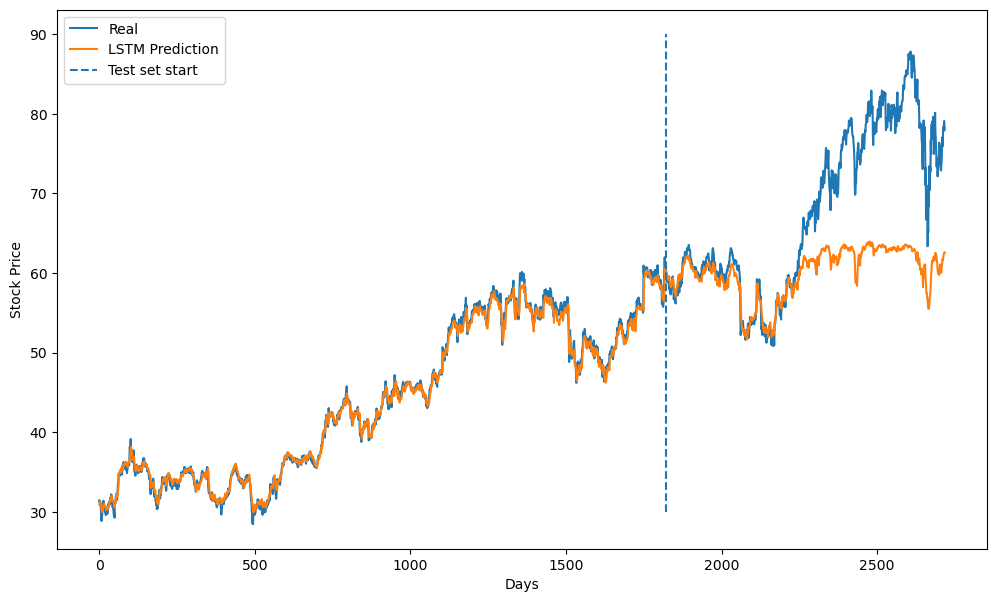

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(range(2718), df_out["Close_lead1"], label = "Real")
plt.plot(range(2718), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

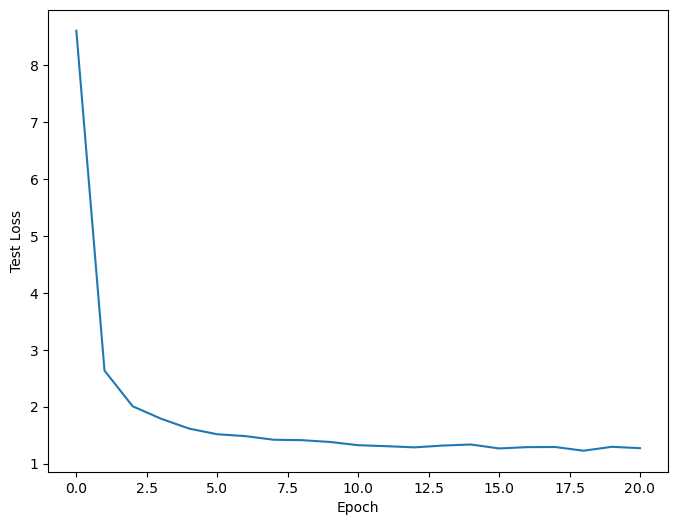

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), classical_loss_test)
plt.ylabel('Test Loss')
# plt.plot(range(1, 21), classical_loss_train)
# plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

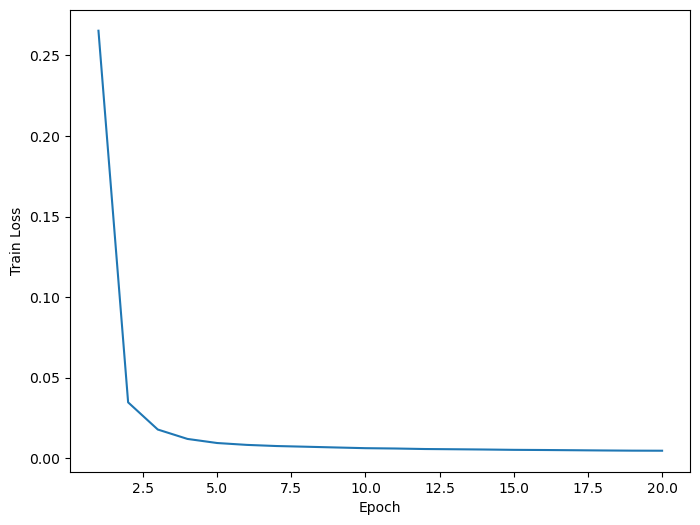

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

# Running the QLSTM

To implement QLSTM, we then replace the 4 key layers of the LSTM with variational quantum layers enabled by Pennylane. The variational quantum layers are based on the following variational quantum circuits:

<img src="vqc.jpg" alt="drawing" width="600"/>

Image taken from: Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf. By Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang

Thus, the parameters to be trained instead becomes the rotational parameters within the circuits, hence forming a hybrid quantum-classical neural network layer (as the optimizer is classical). In the paper on QLSTM, they show that the trainability of the QLSTM is better as "learns significantly more information than the LSTM does right after the first training epoch, and its loss decreases more stably and faster than that of its classical counterpart" (20). Thus, in this study, we hope to show that QLSTM has potential be more accurate and learn more per epoch than its classical counterpart. 

The code for the QLSTM was first taken from:

Example of a QLSTM: https://github.com/rdisipio/qlstm, Riccardo Di Sipio <br>

Although we have repurposed it and changed some of it to fit our purposes, for example to follow the variational quantum quantum circuits shown above. We also use the inbuilt Pennylane simulator to run these variational quantum circuits.

In the following code, we proceed to train a QLSTM model to predict the stock prices of MRK stock, which will provide a proof of concept that QLSTM not only can be used for stock prices prediction, but also has advantages over its classical counterpart. The number of qubits we use is 4, the number of variational layers used is 1, and the learning rate is 0.05. For the number of qubits, we decided on that value as we wanted to show that it was possible even on a small number of qubits; while the latter 2 parameters were decided on by experimentation on a small number of epochs to see which gave the best results. After that, we proceed to see 3 different graphs that we saw in the classical example.

In [22]:
from Factory import QShallowRegressionLSTM

In [23]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [24]:
Qmodel

QShallowRegressionLSTM(
  (lstm): QLSTM(
    (clayer_in): Linear(in_features=48, out_features=4, bias=True)
    (clayer_out): Linear(in_features=4, out_features=16, bias=True)
  )
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [25]:
def test_model(data_loader, Qmodel, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    Qmodel.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = Qmodel(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [26]:
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

In [27]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Test loss: 5.785037507978969
Execution time 33.8080620765686
Epoch 0
---------
Train loss: 0.03394758568795117
Test loss: 1.542624435237186
Execution time 158.0325710773468
Epoch 1
---------
Train loss: 0.00687203275071799
Test loss: 1.283315043884186
Execution time 172.86454916000366
Epoch 2
---------
Train loss: 0.005368385386994308
Test loss: 1.1466257574492913
Execution time 822.3343868255615
Epoch 3
---------
Train loss: 0.004728486059650228
Test loss: 1.1296078688678457
Execution time 149.2318708896637
Epoch 4
---------
Train loss: 0.004557671950620423
Test loss: 1.0994542841089743
Execution time 149.96159720420837
Epoch 5
---------
Train loss: 0.004300861538815707
Test loss: 1.0566104914930974
Execution time 560.6006798744202
Epoch 6
---------
Train loss: 0.0042292476718453235
Test loss: 1.0309533176706596
Execution time 150.08273816108704
Epoch 7
---------
Train loss: 0.00414173187127174
Test loss: 1.0429656181381721
Execution time 154.73599815368652
Epo

In [28]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

      Close_lead1  Model forecast
0       31.440840       30.906479
1       31.183207       31.245687
2       31.364504       31.105980
3       30.839695       31.275185
4       30.944656       30.888901
...           ...             ...
2712    77.814888       64.206726
2713    78.492363       64.231789
2714    79.103050       64.264854
2715    78.492363       64.278122
2716    78.024811       64.281204

[2718 rows x 2 columns]


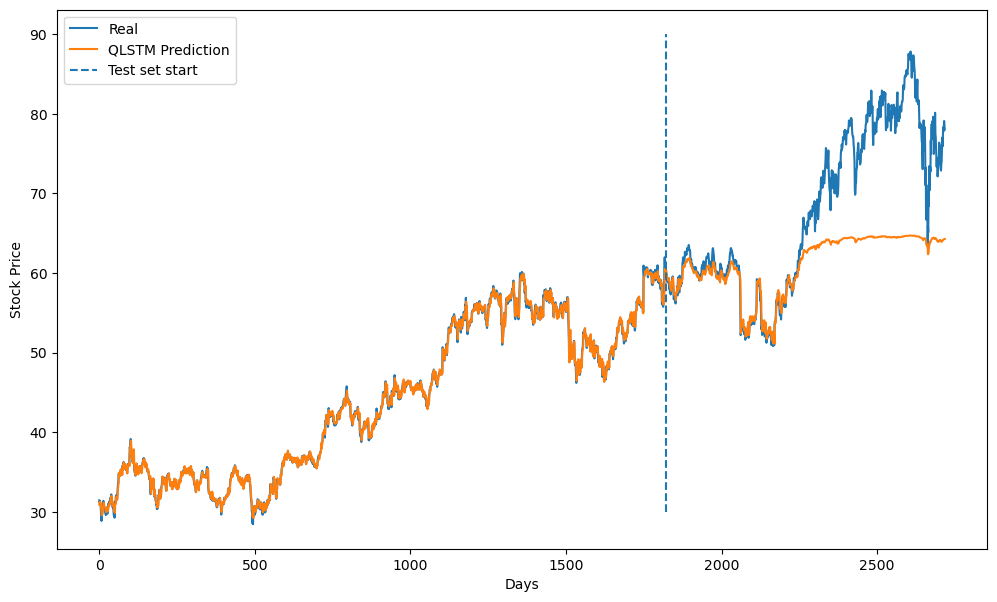

In [29]:
plt.figure(figsize=(12, 7))
plt.plot(range(2718), df_out_Q["Close_lead1"], label = "Real")
plt.plot(range(2718), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

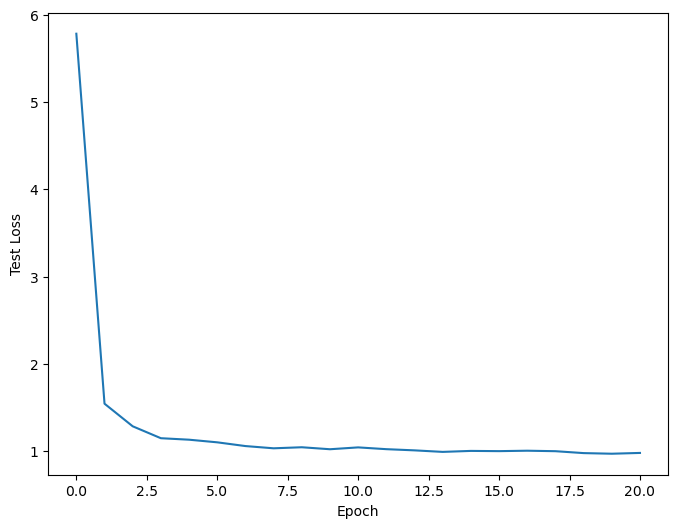

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), quantum_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

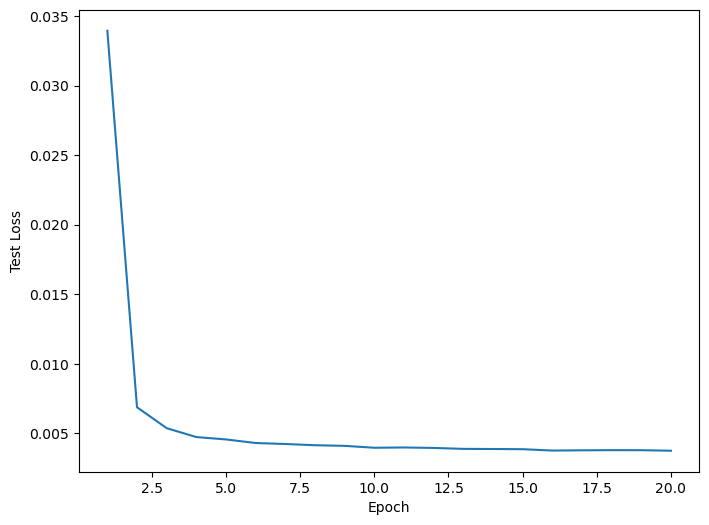

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,21), quantum_loss_train)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

# Comparison between Classical LSTM and QLSTM

Now that we have trained both models and seen some preliminary results on both of them, we want to properly compare the results on the same graph to see how they perform against each other. To do so, we compare them in the following manner:

- Compare the predictions of the models
- Compare the loss per epoch for both training and test loss
- Discuss Complexity analysis, and compare number of parameters

## Comparison of predictions

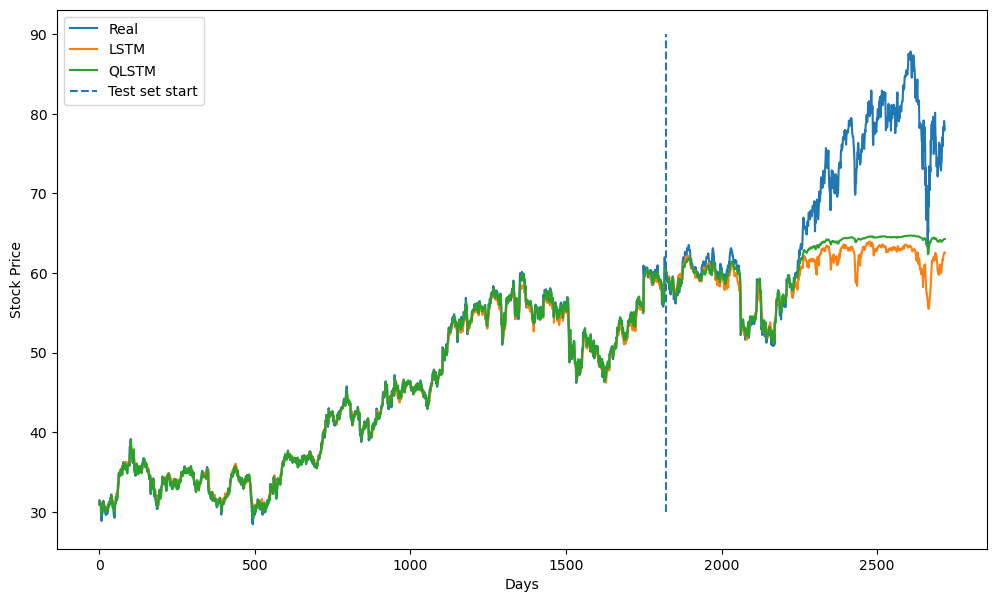

In [32]:
plt.figure(figsize=(12, 7))
plt.plot(range(2718), df_out["Close_lead1"], label = "Real")
plt.plot(range(2718), df_out["Model forecast"], label = "LSTM")
plt.plot(range(2718), df_out_Q["Model forecast"], label = "QLSTM")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

As we can see from the graph, both the LSTM and QLSTM give comparable results. Both manage to predict the training set extremely well, and for a while after the start of the test set, they give extremely accurate predictions for a long period before starting to diverge from the real values. Furthermore, despite their divergence from it, they both still managed to capture some parts of the variation.

## Comparison of evolution of loss values

Next, we want to compare the evolution of the loss values by epoch.

First, we compare the evolution of the train loss.

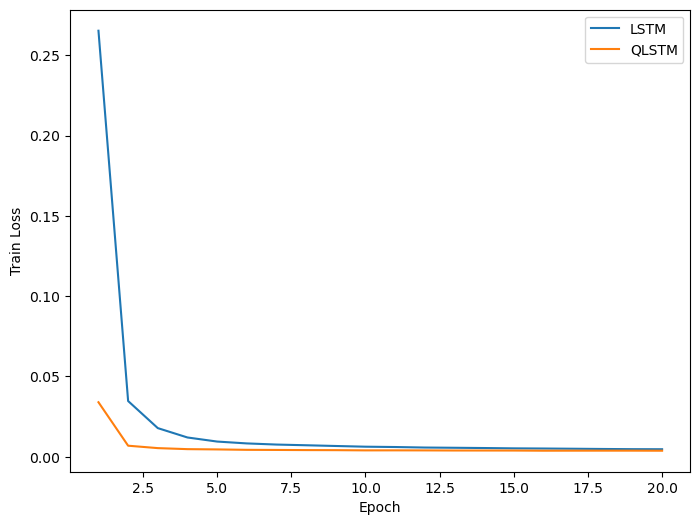

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,21), classical_loss_train, label = "LSTM")
plt.plot(range(1,21), quantum_loss_train, label = "QLSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We see that QLSTM learns much more information in the first few epochs as compared to LSTM, and that the results converge much faster as compared to its classical counterpart, although they both eventually converge to a suitably low value. This shows its improved trainability.

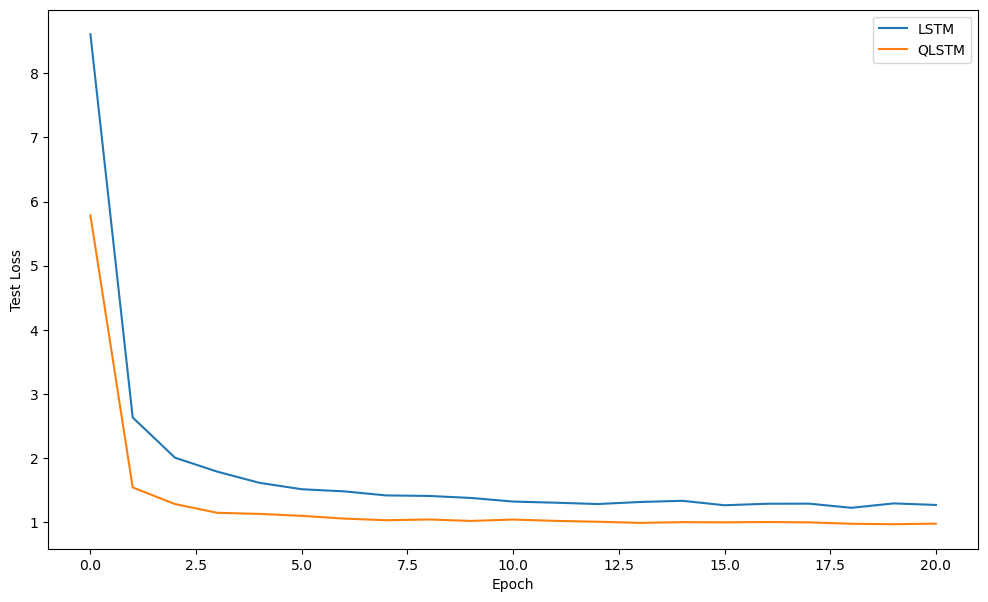

In [34]:
plt.figure(figsize=(12, 7))
plt.plot(range(21), classical_loss_test, label = "LSTM")
plt.plot(range(21), quantum_loss_test, label = "QLSTM")
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Similar to the training loss, we can see that for the test loss, QLSTM learns much more information in the first few epochs as compared to LSTM as well, and converges to a lower value much faster. Even more admirably, the QLSTM converges to an even lower test loss compared to the LSTM, speaking again to its improved trainability, although as can be seen from the results of the predictions that the predictions are still fairly comparable.

## Complexity analysis

For the final point of comparison, we discuss the complexity analysis for the QLSTM, as well as compare the number of parameters used for the LSTM and the QLSTM.

Our goal is to eventually use the QLSTM on real quantum computers, so it would be prudent to discuss its viability in terms of the number of gates and qubits required. Firstly, we discuss the number of qubits. As found in early version of QLSTM, we can use small number of qubits, for instance 4, since we can sandwich LSTM between two classical layers, where the classical layers help to convert the vector sizes to the correct amount, from the embedding of input features into the quantum circuit to the processing of the output measurements. This idea is similar to dressed quantum circuits presented in:

Transfer learning in hybrid classical-quantum neural networks: https://arxiv.org/abs/1912.08278, Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, Nathan Killoran

In the foreseeable future in the NISQ era, we would likely continue to use the same technique, although the number of qubits can be increased to improve the model.

Regarding the number of gates used per circuit, we study that the overall depth increases with increase in number of qubits and number of layers. As shown in the above circuit, the overall depth is $3 + n_l * (2 * n_q + 3)$, where $n_l, n_q$ refers to the number of layers and number of qubits respectively. Thus, the overall depth would increase linearly in both number of qubits and number of layers. Consequently, depth is easy to control, and thus viable for the NISQ era. In this particular proof of example, we show that even when the number of layers is 1 (the smallest it can be) and the number of qubits is small, we still get good results. 

Finally we want to compare the number of parameters used:

In [35]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_Q = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)

print("No. of parameters for Classical LSTM: ", total_params)
print("No. of parameters for QLSTM: ", total_params_Q)

No. of parameters for Classical LSTM:  3217
No. of parameters for QLSTM:  293


The native PyTorch implementation of LSTM uses a huge number of parameters for training, while QLSTM uses comparatively much fewer. This shows the advantage in trainability that QLSTM has over LSTM, where a smaller number of parameters is needed.

# Conclusion and Future Outlook

In this notebook, we have given the proof of concept that QLSTM can be used to great effect for stock price prediction, offering comparable results than its classical counterpart, while requiring significantly fewer parameters to train and getting more information per epoch. This shows that this technique has potential in the financial world since any time series data can be trained using an LSTM and hence also a QLSTM. This is relevant not only to stock price predictions, but also for example company sales predictions or other key performance predictions. However, there are still many areas for improvement.

<b> Improvements on the current model </b>
    
From this submission, we can also see that we have been using fairly bare bones neural network techniques, like setting a fixed learning rate, using a huge number of features, and  a small sequence length. Studies have shown that setting a learning rate scheduler improves the trainability of the model; feature selection is also a key part of data management for machine leanring; and the small sequence length was chosen in interest of time. Even in the current model, although the current decisions we made provides a good proof of concept, there are many areas for improvement, so we intend to implement those improvements in the future. 

<b> Moving from LSTM to GANs </b>
    
As aforementioned, our work was inspired by the study using BERT and GANs to predict stock prices. In the study, the authors use LSTM as the generator in the GAN, which motivated us to use LSTM and improve on LSTM to QLSTM in this submission.

Furthermore, that paper showed that the GAN which used LSTM as a generator was better than merely using LSTM, which gives us a direction to work in for the future. Eventually, we want to move from a simple QLSTM model to a QGAN model which uses QLSTM as the generator, expanding on the current set of literature on QGANs.  We can get a better model for stock price prediction with the implementation of QGANs, and so we intend to proceed in that direction of research.

<b> Caveats </b>

One might argue that the loss decreased a lot faster for QLSTM in comparison with LSTM  due to  different learning rates that we set. However, when experimenting with some of the higher learning rates for the classical LSTM, the result was unable to reach local minimum. We chose this learning rate as it reliably gave accurate results without the issue of convergence. We acknowledge that the result might improve with learning rate scheduler, however the same can be argued for QLSTM, hence we would have to await further experimentation for any conlusion on that argument.